# Trained Quantization & Weight Sharing

In [1]:
import numpy as np
import scipy.io as sio 
import torch.nn as nn
import torch 
import matplotlib.pyplot as plt
import os
import argparse

from preprocessing_funcs import get_spikes_with_history, preprocessing, remove_outliers
from model import LSTM
from trainer import train
from quantizer import quantize_network, compute_quantized_weights, quantized_train

In [2]:
#set this to the root directory where you want to save and load data and figures
root = os.path.join('drive')
#set this to the diectory where you want to save data and checkpoints
data_path = os.path.join(root, 'data')
#set this to the diectory where you want to save checkpoints
checkpoint_path = os.path.join(root, 'checkpoints')

In [27]:
for Idx_subject in list([10]): # 3 subjects index 10-12

       
        for Finger in list([4]): # 5 fingers for each subject. 0:thumb, 1:index, 2:middle ...
            
            #load training data (TrainX: feature vectors, TrainY: labels)
            matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMP.mat')
            TrainX = matData['Data_Feature'].transpose()
            TrainY = matData['SmoothedFinger']
            TrainY = TrainY [:,Finger]
            TrainY = TrainY.reshape(TrainY.shape[0],1)
            #load testing data (TestX: feature vectors, TestY: labels)
            matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMPTest.mat')
            TestX = matData['Data_Feature'].transpose()
            TestY = matData['SmoothedFinger']
            TestY = TestY[:,Finger]
            TestY = TestY.reshape(TestY.shape[0],1)
            
            # preprocessing 
            TrainX = remove_outliers(TrainX)
            
            x_scaler, y_scaler, TrainX, TestX, TrainY, TestY  = preprocessing(TrainX,TestX,TrainY,TestY)
            
            
            # from here, we reconstruct the input by "looking back" a few steps
            bins_before= 20 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding
            
            TrainX=get_spikes_with_history(TrainX,bins_before,bins_after,bins_current)
            TrainX, TrainY = TrainX[bins_before:,:,:], TrainY[bins_before:,]
         
            TestX=get_spikes_with_history(TestX,bins_before,bins_after,bins_current)
            TestX, TestY = TestX[bins_before:,:,:], TestY[bins_before:,]
            
            # Now, we reconstructed TrainX/TestX to have a shape (num_of_samples, sequence_length, input_size)
            # We can fit this to the LSTM
            
            print("Run for subject " + str(Idx_subject) + " finger "+str(Finger))

            n_hidden = 20
            n_layers = 5
            input_dim = TrainX.shape[2]
            output_dim = TrainY.shape[1]
            seq_len =  TrainX.shape[1]

            net = LSTM(input_dim, output_dim, seq_len,  n_hidden, n_layers)

            lossfunc = nn.MSELoss()

            optimizer = torch.optim.Adamax(net.parameters(), lr=0.002)
            net.train()


            ##training the initial model
            PATH_pre_trained = checkpoint_path + '/s'+ str(Idx_subject) + '_f'+str(Finger)+'_trained_model'
            
            net.load_state_dict(torch.load(PATH_pre_trained))

            ##test initial model
            net.eval()
            pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))
            pred = pred.detach().numpy()[-1,:,:]
            pred = y_scaler.inverse_transform(pred)
            TestY = y_scaler.inverse_transform(TestY)
            pred = pred.reshape((-1,))
            corrcoef = np.corrcoef(pred,TestY.reshape((-1,)))

            
            print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=corrcoef[0,1]))   

 

Finger 0: 100%|########################################################################| 60/60 [09:33<00:00,  9.56s/it]


Run for subject 10 finger 4
Correlation coefficient test : 0.3449362379260117


## Quantited Model Before Training

In [64]:
#initialize the quantiezed weights using the weights from the trained netwrok:
k=8
net = compute_quantized_weights(net,k)
#set the model's parameters to their quantized version
net = quantize_network(net)
net.eval()
quant_pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]), quant=True)
quant_pred = quant_pred.detach().numpy()[-1,:,:]
quant_pred = y_scaler.inverse_transform(quant_pred)
TestY = y_scaler.inverse_transform(TestY)
quant_pred = quant_pred.reshape((-1,))
quant_corrcoef = np.corrcoef(quant_pred,TestY.reshape((-1,)))

print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=quant_corrcoef[0,1]))  

Correlation coefficient test : 0.338057174990737


## Quantited Model After Training

In [28]:
#re-loas the weights:
net.load_state_dict(torch.load(PATH_pre_trained))
k=8
#initialize the quantiezed weights using the weights from the trained netwrok:
net = compute_quantized_weights(net,k)
net.train()

#train the quantized netwok
quantized_corr_train, quantized_corr_val, quantized_corr_test = quantized_train(TrainX, TrainY,TestX,TestY, net, lossfunc, optimizer, num_epoch = 30, clip = 5)
#set the model's parameters to their quantized version
net = quantize_network(net)


net.eval()
quant_pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]), quant=True)
quant_pred = quant_pred.detach().numpy()[-1,:,:]
quant_pred = y_scaler.inverse_transform(quant_pred)
TestY = y_scaler.inverse_transform(TestY)
quant_pred = quant_pred.reshape((-1,))
quant_corrcoef = np.corrcoef(quant_pred,TestY.reshape((-1,)))


print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=quant_corrcoef[0,1])) 

Finger 0:   0%|                                                                                 | 0/30 [00:00<?, ?it/s]

Tuning Centroids...


Finger 0: 100%|########################################################################| 30/30 [03:59<00:00,  7.54s/it]

Correlation coefficient test : 0.36211613091441164


## Cluster Distibution

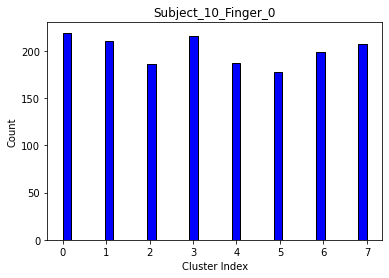

In [65]:
# matplotlib histogram
indices = net.quantized_state_dict['lstm.weight_ih_l4'][0].numpy()
plt.hist(indices, color = 'blue', edgecolor = 'black',
        bins = int(180/5))

plt.title('Subject_'+str(Idx_subject) + '_Finger_' + str(Finger))
plt.xlabel('Cluster Index')
plt.ylabel('Count')

plt.savefig('Subject_'+str(Idx_subject) + 'Finger_' + str(Finger))